In [1]:
import numpy as np
from scipy.stats import rv_discrete
from scipy.special import softmax
import matplotlib.pyplot as plt
from copy import deepcopy
from statistics import mean

In [33]:
def rs(state, action, a, b, c, d, r, l):
    stp = rt = None
    if state == a and action == r:
        stp, rt = c, 0
    elif state == a and action == l:
        stp, rt = b, 0
    elif state == b:
        stp, rt = d, rv + np.random.randn()
    return stp, rt


def rbar(state, action, a, b, r, l, rv):
    if state == a and (action == r or action == l):
        return 0
    elif state == b:
        return rv
    else:
        return 0

def update(state, action, Q, a, b, c, d, r, l):
    maxQ = np.zeros(4)
    for s in range(4):
        maxQ[s] = np.max(Q[s])
    if state == a and action == r:
        return maxQ[c]
    elif state == a and action == l:
        return maxQ[b]
    elif state == b:
        return maxQ[d]
    else:
        return 0


def zeroQ(Q):
    for i in range(4):
        Q[i].fill(0.0)

def alphat(alpha0, t):
    return alpha0 / (1 + 0.001 * t)

def softprob(x):
    x = x - np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

def argmaxR(x):
    p = softmax(1000 * x)
    return np.random.choice(np.arange(len(x)), p=p)

# define states and actions
a, b, c, d = 0, 1, 2, 3
l, r = 0, 1

rv = -0.1
gamma = 0.99
alpha0 = 0.1
eps = 0.1
Exps = 10000
Episodes = 2000

# Initialization
Q = [np.zeros((2,)), np.zeros((8,)), np.zeros((1,)), np.zeros((1,))]
zeroQ(Q)

QA = [np.copy(q) for q in Q]
QB = [np.copy(q) for q in Q]

# Get the true solution to the MDP
Qnew = deepcopy(Q)
zeroQ(Qnew)

for _ in range(1000):
    for state in [a, b, c, d]:
        for action in range(len(Q[state])):
            Qnew[state][action] = rbar(state, action, a, b, r, l, rv) + gamma * update(state, action, Q, a, b, c, d, r, l)
    Q = deepcopy(Qnew)

QmaxTrue = Q[a][l]

# Initialize other necessary variables
Qend = np.zeros((Exps, Episodes))
dQend = np.zeros((Exps, Episodes))
sQend = np.zeros((Exps, Episodes))
cQend = np.zeros((Exps, Episodes))
bQend = np.zeros((Exps, Episodes))


In [34]:
# Standard Q learning
# start_time = time.time()
actionsQ = []

for experiment in range(Exps):
    zeroQ(Q)
    ct = [0]
    actionsQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [0] # dummy initialization
        while True:
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionsQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            Q[st[0]][at[0]] += alpha * (rt + gamma * np.max(Q[stp]) - Q[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        Qend[experiment, episode] = Q[a][l]
    actionsQ.append(actionsQ_ex)

In [35]:
# Double Q learning
# start_time = time.time()
actionsdQ = []
for experiment in range(Exps):
    zeroQ(QA)
    zeroQ(QB)
    ct = [0]
    actionsdQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [1]
        while True:
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(QA[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionsdQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            if np.random.rand() > 0.5: # update A
                astar = argmaxR(QA[stp])
                QA[st[0]][at[0]] += alpha * (rt + gamma * QB[stp][astar] - QA[st[0]][at[0]])
            else: # update B
                bstar = argmaxR(QB[stp])
                QB[st[0]][at[0]] += alpha * (rt + gamma * QA[stp][bstar] - QB[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        dQend[experiment, episode] = QA[a][l]
    actionsdQ.append(actionsdQ_ex)

In [36]:
# Smoothed Q learning (softmax)
# start_time = time.time()
actionssQ = []
q = deepcopy(Q)
for experiment in range(Exps):
    zeroQ(Q)
    ct = [0]
    actionssQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [0]
        beta = 0.1 + 0.1 * (episode - 1)
        while True:
            for s in range(4):
                q[s] = softmax(beta * Q[s])
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionssQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            Q[st[0]][at[0]] += alpha * (rt + gamma * np.sum(q[stp] * Q[stp]) - Q[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        sQend[experiment, episode] = Q[a][l]
    actionssQ.append(actionssQ_ex)
# print("Smoothed Q Learning (softmax) took %s seconds" % (time.time() - start_time))

# Clipped max smoothed Q learning
# start_time = time.time()
actionscQ = []
q = deepcopy(Q)
for experiment in range(Exps):
    zeroQ(Q)
    ct = [0]
    actionscQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [1]
        mu = np.exp(-0.02 * episode)
        A = 2 # number of actions
        while True:
            for s in range(4):
                A = len(Q[s])
                q[s] = np.ones(A) * mu / (A - 1) if A != 1 else np.ones(A)
                as_ = argmaxR(Q[s])
                q[s][as_] = 1 - mu
                if len(q[s]) == 1:
                    q[s] = 1.0
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])
            if np.random.rand() > eps: # select action using maxQ
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])
            actionscQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            Q[st[0]][at[0]] += alpha * (rt + gamma * np.sum(q[stp] * Q[stp]) - Q[st[0]][at[0]])
            if stp == d or stp == c:
                break
            st[0] = stp
        cQend[experiment, episode] = Q[a][l]
    actionscQ.append(actionscQ_ex)
# print("Smoothed Q Learning Clipped max took %s seconds" % (time.time() - start_time))

In [38]:
mu_prior = -0.1  # Based on game mechanism for reward's mean
sigma_prior = 1   # Initial uncertainty
sigma_observation = 1  # Known observation noise

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def update_posterior(mu_prior, sigma_prior, rewards):
    sigma_observation = 1
    epsilon = 1e-10
    sigma_posterior_inverse = 1 / (sigma_prior**2 + epsilon) + (len(rewards) / (sigma_observation**2 + epsilon))
    sigma_posterior = 1 / sigma_posterior_inverse
    mu_posterior_numerator = (mu_prior / (sigma_prior**2 + epsilon)) + (np.sum(rewards) / (sigma_observation**2 + epsilon))
    mu_posterior = sigma_posterior * mu_posterior_numerator
    return mu_posterior, sigma_posterior


actionsBayes = []
q = deepcopy(Q)
for experiment in range(Exps):
    zeroQ(Q)
    rewards_collected = []
    ct = [0]
    actionbQ_ex = []
    for episode in range(Episodes):
        st = [a]
        at = [0]
        mu, _ = update_posterior(mu_prior, sigma_prior, rewards_collected)
        while True:
            adjusted_Q = deepcopy(Q)
            alpha = alphat(alpha0, ct[0])
            for s in range(len(Q)):
                adjusted_Q[s] += mu
                q[s] = softmax(adjusted_Q[s])
            ct[0] += 1
            alpha = alphat(alpha0, ct[0])

            # probabilities = {s: softmax(adjusted_Q[s]) for s in range(len(Q))}
            if np.random.rand() > eps:
                at[0] = argmaxR(Q[st[0]])
            else:
                at[0] = np.random.choice([0, 1])

            actionbQ_ex.append(at[0])
            stp, rt = rs(st[0], at[0], a, b, c, d, r, l)
            rewards_collected.append(rt)
            expected_reward = np.dot(q[stp], Q[stp])  # Compute expected reward based on action probabilities
            Q[st[0]][at] += alpha * (rt + gamma * expected_reward - Q[st[0]][at])

            if stp == d or stp == c:
                break
            st[0] = stp

        # 为下一个周期更新先验
        mu_prior, sigma_prior = update_posterior(mu_prior, sigma_prior,rewards_collected)[-2:]
        bQend[experiment, episode] = Q[a][l]

    actionsBayes.append(actionbQ_ex)

In [40]:
avg_abs_error_Q = np.mean(np.abs(Qend - QmaxTrue), axis=0)
avg_abs_error_dQ = np.mean(np.abs(dQend - QmaxTrue), axis=0)
avg_abs_error_sQ = np.mean(np.abs(sQend - QmaxTrue), axis=0)
avg_abs_error_cQ = np.mean(np.abs(cQend - QmaxTrue), axis=0)
avg_abs_error_bQ = np.mean(np.abs(bQend - QmaxTrue), axis=0)
min_length = min(min(len(sublist) for sublist in actionsQ),
                 min(len(sublist) for sublist in actionsdQ),
                 min(len(sublist) for sublist in actionssQ),
                 min(len(sublist) for sublist in actionscQ),
                 min(len(sublist) for sublist in actionsBayes))
actionsQ_trimmed = [sublist[:min_length] for sublist in actionsQ]
actionsdQ_trimmed = [sublist[:min_length] for sublist in actionsdQ]
actionssQ_trimmed = [sublist[:min_length] for sublist in actionssQ]
actionscQ_trimmed = [sublist[:min_length] for sublist in actionscQ]
actionsbQ_trimmed = [sublist[:min_length] for sublist in actionsBayes]
avg_action_Q = np.mean([[action == l for action in sublist] for sublist in actionsQ_trimmed], axis=0)
avg_action_dQ = np.mean([[action == l for action in sublist] for sublist in actionsdQ_trimmed], axis=0)
avg_action_sQ = np.mean([[action == l for action in sublist] for sublist in actionssQ_trimmed], axis=0)
avg_action_cQ = np.mean([[action == l for action in sublist] for sublist in actionscQ_trimmed], axis=0)
avg_action_bQ = np.mean([[action == l for action in sublist] for sublist in actionsbQ_trimmed], axis=0)

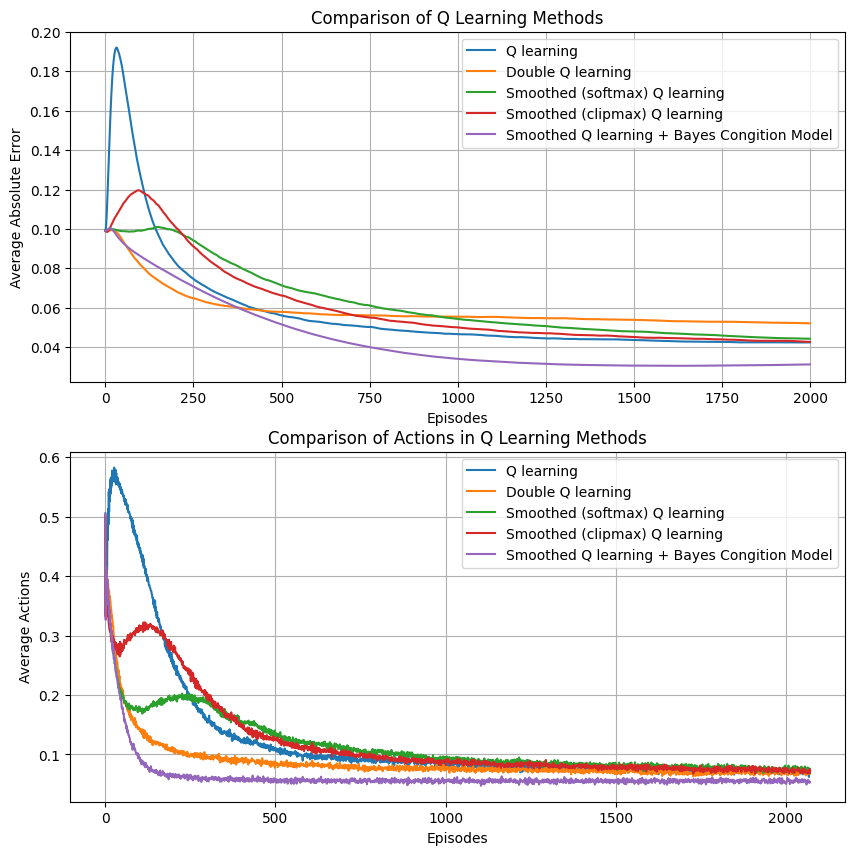

In [42]:
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the average absolute errors for each method
axs[0].plot(avg_abs_error_Q, label='Q learning')
axs[0].plot(avg_abs_error_dQ, label='Double Q learning')
axs[0].plot(avg_abs_error_sQ, label='Smoothed (softmax) Q learning')
axs[0].plot(avg_abs_error_cQ, label='Smoothed (clipmax) Q learning')
axs[0].plot(avg_abs_error_bQ, label='Smoothed Q learning + Bayes Congition Model')
axs[0].legend()
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Average Absolute Error')
axs[0].set_title('Comparison of Q Learning Methods')
axs[0].grid(True)

# Plot the average actions for each method
axs[1].plot(avg_action_Q, label='Q learning')
axs[1].plot(avg_action_dQ, label='Double Q learning')
axs[1].plot(avg_action_sQ, label='Smoothed (softmax) Q learning')
axs[1].plot(avg_action_cQ, label='Smoothed (clipmax) Q learning')
axs[1].plot(avg_action_bQ, label='Smoothed Q learning + Bayes Congition Model')
axs[1].legend()
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Average Actions')
axs[1].set_title('Comparison of Actions in Q Learning Methods')
axs[1].grid(True)
plt.show()